In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from keras.layers import Flatten, Convolution2D, MaxPooling2D, Dropout

import matplotlib.pyplot as plt
import torch
import tensorflow as tf

c:\Users\andre\AppData\Local\Programs\Python\Python37\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pickle

def save_model(model_name, trained_model):
    # save
    with open(f'{model_name}.pkl','wb') as f:
        pickle.dump(trained_model, f)

def load_model(model_name):
    # load
    with open(f'{model_name}.pkl', 'rb') as f:
        return pickle.load(f)

In [3]:
import random

random.seed(10)

# Carga de datos

In [4]:
train_data = pd.read_csv("data/train.csv")
test_data = pd.read_csv("data/validation.csv")

In [5]:
train_data.head()

,sequence_id,target,file
0,1,adios,/Users/andreaamaya/Trabajo/megaproyecto_model/...
1,1,adios,/Users/andreaamaya/Trabajo/megaproyecto_model/...
2,1,adios,/Users/andreaamaya/Trabajo/megaproyecto_model/...
3,1,adios,/Users/andreaamaya/Trabajo/megaproyecto_model/...
4,1,adios,/Users/andreaamaya/Trabajo/megaproyecto_model/...


# Analisis Exploratorio

In [6]:
print("--------------------Train data--------------------")
print(f"Cantidad de filas : {train_data.shape[0]}")
train_letters = list(train_data.target.unique())
train_letters.sort()
print(f"Frases unicas : {train_letters}")

--------------------Train data--------------------
Cantidad de filas : 9294
Frases unicas : ['adios', 'amigo', 'amor', 'ayuda', 'bebida', 'casa', 'comida', 'dinero', 'enfado', 'entender', 'escuela', 'familia', 'feliz', 'gracias', 'hola', 'medico', 'necesitar', 'no', 'por favor', 'querer', 'salud', 'si', 'tiempo', 'trabajo', 'triste']


In [7]:
print("--------------------Test data--------------------")
print(f"Cantidad de filas : {test_data.shape[0]}")
test_letters = list(test_data.target.unique())
test_letters.sort()
print(f"Frases unicas : {test_letters}")

--------------------Test data--------------------
Cantidad de filas : 847
Frases unicas : ['adios', 'amigo', 'amor', 'ayuda', 'bebida', 'casa', 'comida', 'dinero', 'enfado', 'entender', 'escuela', 'familia', 'feliz', 'gracias', 'hola', 'medico', 'necesitar', 'no', 'por favor', 'querer', 'salud', 'si', 'tiempo', 'trabajo', 'triste']


In [8]:
if (test_letters != train_letters):
    raise ValueError("Error between target and train")

In [9]:
train_data.describe()

,sequence_id
count,9294.000000
mean,258.806004
std,160.078342
min,1.000000
25%,120.000000
50%,230.000000
75%,400.000000
max,546.000000


# Preprocesamiento del Modelo

Solo se obtienen 20 indices de las coordenadas x y y, ya que son las unicas que han sido altamente entrenadas del modelo mediapipe de Google

In [10]:
def get_needed_cols():
    cols = []

    for i in range(21):
        cols.append(f'x_Right_hand_{i}')
        cols.append(f'y_Right_hand_{i}')
        cols.append(f'x_Left_hand_{i}')
        cols.append(f'y_Left_hand_{i}')
    
    return cols

In [11]:
df = pd.read_csv("data/data.csv")
df_test = df[df['sequence_id'].isin(test_data['sequence_id'])]
df_train = df[df['sequence_id'].isin(train_data['sequence_id'])]

In [12]:
df.head()

,sequence_id,target,x_Left_hand_0,y_Left_hand_0,x_Left_hand_1,y_Left_hand_1,x_Left_hand_2,y_Left_hand_2,x_Left_hand_3,y_Left_hand_3,...,x_Right_hand_16,y_Right_hand_16,x_Right_hand_17,y_Right_hand_17,x_Right_hand_18,y_Right_hand_18,x_Right_hand_19,y_Right_hand_19,x_Right_hand_20,y_Right_hand_20
0,1,adios,0.189560,0.0,0.689331,0.109569,0.907900,0.290353,0.937767,0.462094,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,adios,0.261204,0.0,0.673647,0.132535,0.875866,0.333381,0.931140,0.498942,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,adios,0.179029,0.0,0.642707,0.112931,0.868939,0.298907,0.917407,0.466914,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,adios,0.364079,0.0,0.754242,0.154486,0.963624,0.357678,1.000000,0.522868,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,adios,0.588405,0.0,0.895435,0.207583,1.000000,0.423537,0.926369,0.583810,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
print(len(df))
print(len(df_test) == len(test_data))
print(len(df_train) == len(train_data))

10141
True
True


# Modelo

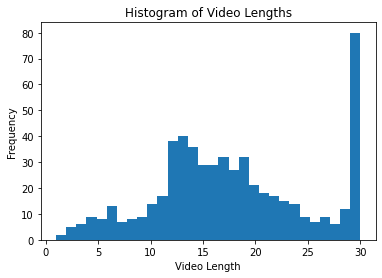

In [14]:
# Compute the lengths of the video sequences
video_lengths = df.groupby('sequence_id').size()
max_seq_length = video_lengths.max()
# max_seq_length = 30
# Plot the histogram
plt.hist(video_lengths, bins=30)  # Adjust the number of bins as needed
plt.xlabel('Video Length')
plt.ylabel('Frequency')
plt.title('Histogram of Video Lengths')
plt.show()

In [15]:
video_lengths.max()

30

In [16]:
# Create a one-hot encoder
label_encoder = LabelEncoder()

In [17]:
def padding_videos(df):
    # Create a new DataFrame to store the filled rows
    filled_df = pd.DataFrame()
    target = []


    # Iterate over each group and fill remaining rows with zero
    for _, group in df.groupby('sequence_id'):
        remaining_rows = max_seq_length - len(group)
        zeros_df = pd.DataFrame([[0] * len(group.columns)] * remaining_rows, columns=group.columns)
        zeros_df['sequence_id'] = group['sequence_id'].unique()[0]
        zeros_df['target'] = group['target'].unique()[0]
        group = pd.concat([group, zeros_df])
    
        # filled_df = filled_df.append(group)
        filled_df = pd.concat([filled_df, group])
        target.append(group["target"].unique()[0])
        
    filled_df.reset_index(drop=True, inplace=True)
    filled_df = filled_df.fillna(0)
    return filled_df, target

def padding_labels(target):
    integer_encoded = label_encoder.fit_transform(target)
    integer_encoded = integer_encoded.reshape(-1, 1)

    # Encode the word "Hello"
    onehot_encoder = OneHotEncoder(sparse=False)  # sparse=False to get a numpy array as output
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    return onehot_encoded

In [18]:
X_train, target = padding_videos(df_train)
y_train = padding_labels(target)

In [19]:

del X_train["sequence_id"] 
del X_train["target"] 

print(len(X_train), len(y_train))

15720 524


In [20]:
X_test, target = padding_videos(df_test)
y_test = padding_labels(target)
del X_test["sequence_id"] 
del X_test["target"] 

print(len(X_test), len(y_test))

1350 45


In [21]:
len(y_train) + len(y_test) == len(df["sequence_id"].unique())

True

In [22]:
def flat_X(X):
    # Define the number of rows to be flattened
    rows_to_flatten = max_seq_length

    data_array = X.to_numpy()

    # Get the number of resulting rows in the output array
    resulting_rows = data_array.shape[0] // rows_to_flatten

    # Reshape the array to have (resulting_rows, rows_to_flatten, 80) shape
    reshaped_array = data_array[:resulting_rows * rows_to_flatten].reshape(resulting_rows, rows_to_flatten, -1)

    # Flatten the reshaped array along the second axis (axis=1) to get (resulting_rows, 13600) shape
    flattened_array = reshaped_array.reshape(resulting_rows, -1)

    return flattened_array

In [23]:
X_test_flat = flat_X(X_test)

In [24]:
num_samples = int(len(X_test)/max_seq_length)
num_features = len(get_needed_cols())
num_classes = len(y_test[1])

X_test = X_test.values.reshape(num_samples, max_seq_length, num_features)

In [25]:
len(X_train)

15720

In [26]:
X_train_flat = flat_X(X_train)
X_train_flat.shape

(524, 2520)

In [27]:
num_samples_train = int(len(X_train)/max_seq_length)
num_features_train = len(get_needed_cols())
num_classes_train = len(y_train[1])

X_train = X_train.values.reshape(num_samples_train, max_seq_length, num_features_train)

In [28]:
print('Train:', X_train.shape, y_train.shape)
print('Test:', X_test.shape, y_test.shape)

Train: (524, 30, 84) (524, 25)
Test: (45, 30, 84) (45, 25)


# Modelo
La entrada son las coordenadas de las manos. Cada video cuenta con n cantidad de filas, 84 columnas (21 columnas por cada coordenada y por ambas manos).
La salida es la frase. La frase se representa por un entero que da el one hot encoder.

Se usa convoluciones para resaltar las caracteristicas en la entrada. Debido a que la entrada son coordenadas normalizadas de un video, se supone que funciona igual que si la entrada fuera una imagen. Estas redes extraen caracteristicas de forma automatica para clasificar objetos luego. Al buscar patrones, se espera que pueda predecir un video que ya ha sido entrenado previamente.

Se reduce el tamaño de la entrada haciendo uso de max pooling y flatten.

Se hace uso de Dense para conectar entradas con salidas.

Se hace uso de Dropout para evitar el sobreajuste.

Relu elimina negativos. 
Sigmoid nos ayuda a obtener la probabilidad de que un ejemplo pertenezca a la clase positiva.
Softmax hace clasificacion multiclase (en nuestro caso las palabras a predecir).

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [30]:
# Create a sequential model
cnn_model = Sequential()
cnn_model.add(Convolution2D(32, (3, 3), padding="same", input_shape=(max_seq_length, num_features_train, 1), activation='relu'))
# cnn_model.add(Convolution2D(32, (3, 3), padding="same", activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model.add(Convolution2D(64, (3, 3), activation='relu'))
# cnn_model.add(Convolution2D(64, (3, 3), padding="same", activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model.add(Convolution2D(128, (3, 3), activation='relu'))
# cnn_model.add(Convolution2D(128, (3, 3), padding="same", activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))


cnn_model.add(Convolution2D(256, (3, 3), padding="same", activation='relu'))
# # cnn_model.add(Convolution2D(256, (3, 3), padding="same", activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

# cnn_model.add(MaxPooling2D(pool_size=(2, 2)))


cnn_model.add(Flatten())

# cnn_model.add(Dense(512, activation='relu'))
# cnn_model.add(Dense(64,activation ="relu"))
# cnn_model.add(Dense(128,activation ="relu"))
cnn_model.add(Dense(256, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(num_classes_train, activation='softmax'))

In [31]:
# Compile the model
cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = cnn_model.fit(X_train, y_train, epochs=50, batch_size=8, validation_data=(X_test, y_test))
# Get the predictions from the model
y_pred_cnn = cnn_model.predict(X_test)# Find the most likely prediction for each sample

most_likely_predictions = np.argmax(y_pred_cnn, axis=1)
cnn_test_pred = label_encoder.inverse_transform(most_likely_predictions)

test_loss, test_accuracy = cnn_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")

Epoch 1/50
66/66 [==============================] - 2s 20ms/step - loss: 3.1943 - accuracy: 0.0553 - val_loss: 3.1276 - val_accuracy: 0.0667
Epoch 2/50
66/66 [==============================] - 1s 17ms/step - loss: 2.9464 - accuracy: 0.1031 - val_loss: 2.9983 - val_accuracy: 0.0889
Epoch 3/50
66/66 [==============================] - 1s 17ms/step - loss: 2.7830 - accuracy: 0.1298 - val_loss: 2.8649 - val_accuracy: 0.1111
Epoch 4/50
66/66 [==============================] - 1s 17ms/step - loss: 2.5906 - accuracy: 0.1603 - val_loss: 2.7717 - val_accuracy: 0.1111
Epoch 5/50
66/66 [==============================] - 1s 17ms/step - loss: 2.2962 - accuracy: 0.2595 - val_loss: 2.6642 - val_accuracy: 0.2000
Epoch 6/50
66/66 [==============================] - 1s 17ms/step - loss: 1.9499 - accuracy: 0.3645 - val_loss: 2.5161 - val_accuracy: 0.2000
Epoch 7/50
66/66 [==============================] - 1s 17ms/step - loss: 1.7040 - accuracy: 0.4256 - val_loss: 2.1956 - val_accuracy: 0.4444
Epoch 8/50
66

In [32]:
# Inverse one-hot encoding
inverse_encoded_data = np.argmax(y_train, axis=1)
y_train_tree = label_encoder.inverse_transform(inverse_encoded_data)
# Inverse one-hot encoding
inverse_encoded_data = np.argmax(y_test, axis=1)
y_test_tree = label_encoder.inverse_transform(inverse_encoded_data)

In [33]:
class_weights = class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y_train_tree),
                                        y = y_train_tree                                                    
                                    )
class_weights = dict(zip(np.unique(y_train_tree), class_weights))
class_weights

{'adios': 1.3973333333333333,
 'amigo': 0.9527272727272728,
 'amor': 1.048,
 'ayuda': 1.1644444444444444,
 'bebida': 0.9527272727272728,
 'casa': 0.9527272727272728,
 'comida': 0.9113043478260869,
 'dinero': 1.1031578947368421,
 'enfado': 0.9113043478260869,
 'entender': 0.9980952380952381,
 'escuela': 0.9113043478260869,
 'familia': 1.048,
 'feliz': 0.8384,
 'gracias': 0.9980952380952381,
 'hola': 0.9527272727272728,
 'medico': 0.9527272727272728,
 'necesitar': 0.9527272727272728,
 'no': 1.1644444444444444,
 'por favor': 1.2329411764705882,
 'querer': 0.9980952380952381,
 'salud': 0.8733333333333333,
 'si': 1.31,
 'tiempo': 0.9113043478260869,
 'trabajo': 0.9113043478260869,
 'triste': 0.9527272727272728}

In [34]:
# Create an AdaBoost classifier with a base model (e.g., DecisionTreeClassifier)
base_model = DecisionTreeClassifier(max_depth=num_classes_train - 1, min_samples_split=6, min_samples_leaf=4, class_weight=class_weights)
decision_tree = AdaBoostClassifier(base_model, n_estimators=300, random_state=42)

# Fit the ensemble model
decision_tree.fit(X_train_flat, y_train_tree)

# Make predictions
y_pred_tree = decision_tree.predict(X_test_flat)

# Calculate the accuracy score on a test dataset
accuracy_tree = decision_tree.score(X_test_flat, y_test_tree)

# Print the accuracy
print(f'Accuracy: {accuracy_tree:.2f}')

Accuracy: 0.80


In [35]:
# Create an SVC classifier
svm_classifier = SVC(C=0.1, kernel="linear", gamma=0.001, class_weight=class_weights)
# Fit the grid search to your training data
svm_classifier.fit(X_train_flat, y_train_tree)
# Evaluate the model on the test data
y_pred_svm = svm_classifier.predict(X_test_flat)

# Calculate the accuracy score on a test dataset
accuracy_svm = svm_classifier.score(X_test_flat, y_test_tree)

# Print the accuracy
print(f'Accuracy: {accuracy_svm:.2f}')

Accuracy: 0.64


In [36]:
cnn_model.save('cnn')
save_model("tree", decision_tree)
save_model("svm", svm_classifier)

INFO:tensorflow:Assets written to: cnn\assets


INFO:tensorflow:Assets written to: cnn\assets


In [37]:
save_model("label_encoder", label_encoder)

In [38]:
results_to_use = []

accuracies = {
    "SVM": accuracy_svm,
    "TREE": accuracy_tree,
    "CNN": test_accuracy
}
# Find the key with the maximum value
max_key = max(accuracies, key=accuracies.get)

if (max_key == "SVM"):
    results_to_use = y_pred_svm
elif (max_key == "TREE"):
    results_to_use = y_pred_tree
else:
    results_to_use = cnn_test_pred


print("USANDO", max_key)

USANDO TREE


In [39]:
correct = 0
for i in range(len(y_test_tree)):
    if (
        y_test_tree[i] == results_to_use[i]):
        correct += 1
        # print("Correctamente predicha: ", y_pred[i])
    else:
        print(">>> LOG INCORRECTA: ")
        print("            SVM: ", y_pred_svm[i])
        print("            TREE: ", y_pred_tree[i])
        print("            CNN: ", cnn_test_pred[i])
        print("            Correcto: ", y_test_tree[i])


>>> LOG INCORRECTA: 
            SVM:  medico
            TREE:  tiempo
            CNN:  tiempo
            Correcto:  familia
>>> LOG INCORRECTA: 
            SVM:  medico
            TREE:  medico
            CNN:  medico
            Correcto:  querer
>>> LOG INCORRECTA: 
            SVM:  hola
            TREE:  hola
            CNN:  hola
            Correcto:  adios
>>> LOG INCORRECTA: 
            SVM:  casa
            TREE:  casa
            CNN:  casa
            Correcto:  hola
>>> LOG INCORRECTA: 
            SVM:  amigo
            TREE:  salud
            CNN:  escuela
            Correcto:  ayuda
>>> LOG INCORRECTA: 
            SVM:  amor
            TREE:  amor
            CNN:  feliz
            Correcto:  feliz
>>> LOG INCORRECTA: 
            SVM:  familia
            TREE:  salud
            CNN:  ayuda
            Correcto:  escuela
>>> LOG INCORRECTA: 
            SVM:  ayuda
            TREE:  salud
            CNN:  ayuda
            Correcto:  escuela
>>> LOG 

In [40]:
print("Correct >> ", correct)
print("Incorrect >> ", len(y_test_tree)-correct)
print("Ratio >> ", str(correct/len(y_test_tree)))

Correct >>  36
Incorrect >>  9
Ratio >>  0.8


# Reutilizando el modelo

In [41]:
load_test_data = pd.read_csv("data/data_tests.csv")
load_test_data.head()

,sequence_id,target,file,x_Left_hand_0,y_Left_hand_0,x_Left_hand_1,y_Left_hand_1,x_Left_hand_2,y_Left_hand_2,x_Left_hand_3,...,x_Right_hand_16,y_Right_hand_16,x_Right_hand_17,y_Right_hand_17,x_Right_hand_18,y_Right_hand_18,x_Right_hand_19,y_Right_hand_19,x_Right_hand_20,y_Right_hand_20
0,572,8_amor,/Users/andreaamaya/Trabajo/megaproyecto_model/...,0.054473,1.0,0.000000,0.814200,0.160031,0.556190,0.309921,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,572,8_amor,/Users/andreaamaya/Trabajo/megaproyecto_model/...,0.000000,1.0,0.029350,0.790749,0.165903,0.539861,0.297188,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,572,8_amor,/Users/andreaamaya/Trabajo/megaproyecto_model/...,0.142526,1.0,0.000000,0.774022,0.049066,0.554538,0.182988,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,572,8_amor,/Users/andreaamaya/Trabajo/megaproyecto_model/...,0.905454,0.0,1.000000,0.403292,0.906272,0.728733,0.641322,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,572,8_amor,/Users/andreaamaya/Trabajo/megaproyecto_model/...,1.000000,0.0,0.998621,0.381168,0.810052,0.691714,0.574807,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
cant_videos = len(load_test_data["sequence_id"].unique())
cant_videos

7

In [43]:
padded_data, target = padding_videos(load_test_data)
del padded_data["sequence_id"] 
del padded_data["target"] 
del padded_data["file"] 

In [44]:
predicted = None
if (max_key == "SVM"):
    X_val = flat_X(padded_data)
    model = load_model("svm")
elif (max_key == "TREE"):
    X_val = flat_X(padded_data)
    model = load_model("tree")
else:
    X_val = padded_data.values.reshape(cant_videos, max_seq_length, num_features_train)
    model = tf.keras.models.load_model("cnn")

In [45]:
predicted = model.predict(X_val)

In [49]:
if (max_key == "CNN"):
    most_likely_predictions = np.argmax(predicted, axis=1)
    predicted = label_encoder.inverse_transform(most_likely_predictions)

In [51]:
target

['8_amor', '1_familia', '5_casa', '3_hola', '6_bebida', '4_tiempo', '9_amigo']

In [52]:
predicted

array(['amor', 'familia', 'casa', 'gracias', 'bebida', 'tiempo', 'amigo'],
      dtype='<U9')

In [53]:
correct = 0
for i in range(cant_videos):
    if (predicted[i] == target[i].split("_")[1]):
        correct += 1

print(f'Palabras correctas: {correct} de {cant_videos}')

Palabras correctas: 6 de 7
